In [1]:
!pip install pandas numpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data (adjust paths as needed)
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')
users = pd.read_csv('ml-1m/users.dat', sep='::', names=['user_id', 'gender', 'age', 'occupation', 'zip'], engine='python')
movies = pd.read_csv('ml-1m/movies.dat', sep='::', names=['movie_id', 'title', 'genres'], engine='python', encoding='latin-1')

# Merge ratings with user and movie info
data = pd.merge(ratings, users, on='user_id')
data = pd.merge(data, movies, on='movie_id')

# Sort entire dataset by user and timestamp
data = data.sort_values(['user_id', 'timestamp'])
print("Done")
data.head()

Done


,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
31,1,3186,4,978300019,F,1,10,48067,"Girl, Interrupted (1999)",Drama
22,1,1270,5,978300055,F,1,10,48067,Back to the Future (1985),Comedy|Sci-Fi
27,1,1721,4,978300055,F,1,10,48067,Titanic (1997),Drama|Romance
37,1,1022,5,978300055,F,1,10,48067,Cinderella (1950),Animation|Children's|Musical
24,1,2340,3,978300103,F,1,10,48067,Meet Joe Black (1998),Romance


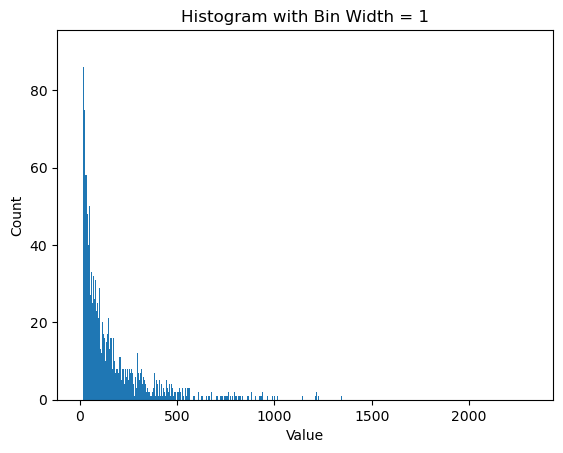

Movies: 3883
Users: 6040
	Any rating
Users with suitable n. of ratings: 4737 (78.42%)
	Positive rating
Users with suitable n. of ratings: 4430 (73.34%)
	Only rated films
Unrated films: 177
Users with suitable n. of ratings: 4430 (73.34%)


In [5]:
# Group by user_id
grouped = data.groupby('user_id')
card_ratings = []
for user_id, user_data in grouped:
    card_ratings.append(len(user_data))


plt.figure()
plt.hist(card_ratings, bins=range(0, max(card_ratings) + 2), align='left')
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram with Bin Width = 1")
plt.show()


######### Parameter to choose
rel_cand = 10
noise_cand = 290
noise_cand = 290*(4/3)



n_film = len(movies)
print("Movies:", n_film)
print("Users:", len(users))
min_n_rating = sum([(x >= rel_cand*4 and x <= n_film-(rel_cand+noise_cand)*3) for x in card_ratings])
print("\tAny rating")
print("Users with suitable n. of ratings:", min_n_rating, f"({int(min_n_rating*10000/len(users))/100}%)")

grouped = (data[data["rating"] >= 3]).groupby('user_id')
card_ratings = []
for user_id, user_data in grouped:
    card_ratings.append(len(user_data))

min_n_rating = sum([( x >= rel_cand*4 and x <= n_film-(rel_cand+noise_cand)*3) for x in card_ratings])
print("\tPositive rating")
print("Users with suitable n. of ratings:", min_n_rating, f"({int(min_n_rating*10000/len(users))/100}%)")

film_rating_join = pd.merge(movies, ratings, on='movie_id', how="left")
unrated_films = film_rating_join[film_rating_join["rating"].isna()]
print("\tOnly rated films")
print("Unrated films:", len(unrated_films))
min_n_rating = sum([( x >= rel_cand*4 and x <= n_film-(rel_cand+noise_cand)*3-len(unrated_films)) for x in card_ratings])
print("Users with suitable n. of ratings:", min_n_rating, f"({int(min_n_rating*10000/len(users))/100}%)")

In [6]:
film_rating_join = pd.merge(movies, ratings, on='movie_id', how="left")
rated_films = film_rating_join[film_rating_join["rating"].notnull()]
rated_films = list(set(rated_films["movie_id"]))

n_film = len(rated_films)

grouped = ((data[data["rating"] >= 3])
            .groupby('user_id', as_index=False)
            .agg(
                n_rating=("rating", "size"),
            )
          )
relevant_users = grouped[grouped["n_rating"] >= rel_cand*4]
relevant_users = relevant_users[relevant_users["n_rating"] <= n_film-noise_cand*3]
relevant_users = list(set(relevant_users["user_id"]))

print("Rated films:", len(rated_films))
print("Useful users", len(relevant_users))

Rated films: 3706
Useful users 4430


In [7]:
grouped = (data[data["rating"] >= 3]).groupby('user_id', as_index=False)

oo_user = []
for user_id, user_data in grouped:
    if (user_id in relevant_users):
        user_rated_films = user_data.sort_values(by="timestamp", ascending=False)
        
        user_rated_films_ids = list(user_rated_films['movie_id'])
        
        user_unrated_films_ids = [film_id for film_id in rated_films if film_id not in user_rated_films_ids]
    
        mask = movies['movie_id'].isin(user_unrated_films_ids)
        user_unrated_films = movies[mask]
        
        user_obj = {
            'user_id': user_id,
            'n_ratings': len(user_rated_films),
            'n_unratings': len(user_unrated_films),
            'rated_films_df': user_rated_films,
            'unrated_films_df': user_unrated_films
        }
        oo_user.append([user_id, user_obj])


In [8]:
problematic = []

for [user_id, user_obj] in oo_user:
    if user_obj['n_ratings'] < rel_cand*4 or user_obj['n_unratings'] < noise_cand*3:
        problematic.append(user_id)

print(len(oo_user))
print(len(problematic))


4430
0


In [13]:
user_TTE_split_df = pd.DataFrame(columns=['user_id','train_h','train_c','train_n',
                                                    'test_h','test_c','test_n',
                                                    'eval_h','eval_c','eval_n'])
head = True
pos_noise = int(noise_cand*(3/4))
for [user_id, user_obj] in oo_user:
    sorted_ratings = user_obj['rated_films_df'].sort_values(by="timestamp", ascending=False)
    sorted_ids = sorted_ratings['movie_id'][:rel_cand*4]
    train_h = sorted_ids[rel_cand*3:rel_cand*4]
    train_c = sorted_ids[rel_cand*2:rel_cand*3]
    test_h = train_c
    test_c = sorted_ids[rel_cand*1:rel_cand*2]
    eval_h = test_c
    eval_c = sorted_ids[0:rel_cand*1]
    #print(len(user_obj['unrated_films_df']))
    counts = ratings['movie_id'].value_counts()
    unrated_films = user_obj['unrated_films_df'].copy()
    unrated_films['rating_count'] = unrated_films['movie_id'].map(counts).fillna(0).astype(int)
    unrated_films = unrated_films.sort_values(by='rating_count', ascending=False)
    #print(len(unrated_films))
    #print(unrated_films.head())
    #noise = user_obj['unrated_films_df'].sample(n=120, random_state=1)
    noise = unrated_films.head(int(noise_cand*3))
    noise = noise.sample(n=len(noise), random_state=1)
    #print(noise.head())
    train_n = noise['movie_id'][0:pos_noise]
    test_n = noise['movie_id'][pos_noise:pos_noise*2]
    eval_n = noise['movie_id'][pos_noise*2:pos_noise*3]
    user_TTE_split_df.loc[len(user_TTE_split_df)] = [user_id,train_h,train_c,train_n,
                                                            test_h,test_c,test_n,
                                                            eval_h,eval_c,eval_n]
  

In [15]:
import os
os.makedirs(f'TTE_uf{pos_noise}', exist_ok=True)
user_TTE_split_df.to_json(f'TTE_uf{pos_noise}/TTE_user_split_uf{pos_noise}.json', orient='records', indent=2)